In [2]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

In [3]:
def rgb2gray(img):
    r = img[:, :, 0].copy()
    g = img[:, :, 1].copy()
    b = img[:, :, 2].copy()

    out = 0.2126 * r + 0.7152 * g + 0.0722 * b
    out = out.astype(np.uint8)
    return out

In [4]:
def gaussian_filter(img, K_size=3, sigma=1.3):

    if len(img.shape) == 3:
        H, W, C = img.shape
        gray = False
    else:
        img = np.expand_dims(img, axis=-1)
        H, W, C = img.shape
        gray = True

    pad = K_size // 2
    out = np.zeros([H + pad * 2, W + pad * 2, C], dtype=np.float)
    out[pad: pad + H, pad: pad + W] = img.copy().astype(np.float)

    K = np.zeros((K_size, K_size), dtype=np.float)
    for x in range(-pad, -pad + K_size):
        for y in range(-pad, -pad + K_size):
            K[y + pad, x + pad] = np.exp( - (x ** 2 + y ** 2) / (2 * (sigma ** 2)))
    K /= (2 * np.pi * sigma * sigma)
    K /= K.sum()

    tmp = out.copy()

    for y in range(H):
        for x in range(W):
            for c in range(C):
                out[pad + y, pad + x, c] = np.sum(K * tmp[y : y + K_size, x : x + K_size, c]) 

    out = np.clip(out, 0, 255)
    out = out[pad : pad + H, pad : pad + W]
    #out = out.astype(np.uint8)

    if gray:
        out = out[..., 0]

    return out

In [5]:
def sobel_filter(img, K_size=3):
    if len(img.shape) == 3:
        H, W, C = img.shape
    else:
        #img = np.expand_dims(img, axis=-1)
        H, W = img.shape

    pad = K_size // 2
    out = np.zeros((H + pad * 2, W + pad * 2), dtype=np.float)
    out[pad : pad + H, pad : pad + W] = img.copy().astype(np.float)
    tmp = out.copy()

    out_v = out.copy()
    out_h = out.copy()

    Kv = [[1., 2., 1.],[0., 0., 0.], [-1., -2., -1.]]
    Kh = [[1., 0., -1.],[2., 0., -2.],[1., 0., -1.]]

    for y in range(H):
        for x in range(W):
            out_v[pad + y, pad + x] = np.sum(Kv * (tmp[y : y + K_size, x : x + K_size]))
            out_h[pad + y, pad + x] = np.sum(Kh * (tmp[y : y + K_size, x : x + K_size]))

    out_v = np.clip(out_v, 0, 255)
    out_h = np.clip(out_h, 0, 255)

    out_v = out_v[pad : pad + H, pad : pad + W].astype(np.uint8)
    out_h = out_h[pad : pad + H, pad : pad + W].astype(np.uint8)

    return out_v, out_h

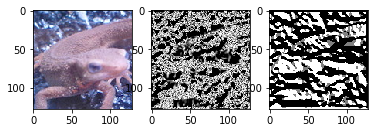

In [6]:
#41 ?????????????????????
def canny_edge12(img):
    gray = rgb2gray(img)
    g = gaussian_filter(gray, K_size=5, sigma=1.4)
    fy, fx = sobel_filter(g, K_size=3)
    
    edge = np.sqrt(np.power(fx, 2) + np.power(fy, 2))
    fx = np.maximum(fx, 1e-5)
    
    angle = np.arctan(fy / fx)

    angle = 180 * angle / np.pi
    angle[angle < -22.5] = angle[angle < -22.5] + 180

    _angle = np.zeros_like(angle, dtype=np.uint8)
    _angle[np.where(angle <= 22.5)] = 0
    _angle[np.where((angle > 22.5) & (angle <= 67.5))] = 45
    _angle[np.where((angle > 67.5) & (angle <= 112.5))] = 90
    _angle[np.where((angle > 112.5) & (angle <= 157.5))] = 135
    
    edge = edge.astype(np.uint8)
    return edge, _angle


img = cv2.imread('imori.jpg')
img = img[..., ::-1]

out1, out2 = canny_edge12(img)

plt.subplot(1, 3, 1)
plt.imshow(img)
plt.subplot(1, 3, 2)
plt.imshow(out1, cmap='gray')
plt.subplot(1, 3, 3)
plt.imshow(out2, cmap='gray')
plt.show()

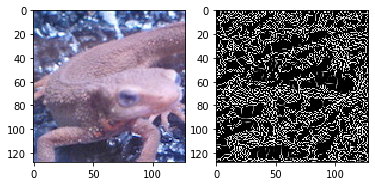

In [7]:
#42 ???????????????????????????
def canny_edge3(edge, angle):
    H, W = angle.shape
    _edge = edge.copy()
    
    for y in range(H):
        for x in range(W):
            if angle[y, x] == 0:
                dx1, dy1, dx2, dy2 = -1, 0, 1, 0
            elif angle[y, x] == 45:
                dx1, dy1, dx2, dy2 = -1, 1, 1, -1
            elif angle[y, x] == 90:
                dx1, dy1, dx2, dy2 = 0, -1, 0, 1
            elif angle[y, x] == 135:
                dx1, dy1, dx2, dy2 = -1, -1, 1, 1
            if x == 0:
                dx1 = max(dx1, 0)
                dx2 = max(dx2, 0)
            if x == W-1:
                dx1 = min(dx1, 0)
                dx2 = min(dx2, 0)
            if y == 0:
                dy1 = max(dy1, 0)
                dy2 = max(dy2, 0)
            if y == H-1:
                dy1 = min(dy1, 0)
                dy2 = min(dy2, 0)
            if max(max(edge[y, x], edge[y + dy1, x + dx1]), edge[y + dy2, x + dx2]) != edge[y, x]:
                _edge[y, x] = 0

    return _edge


img = cv2.imread('imori.jpg')
img = img[..., ::-1]

edge, angle = canny_edge12(img)
out = canny_edge3(edge, angle)

plt.subplot(1, 2, 1)
plt.imshow(img, cmap='gray')
plt.subplot(1, 2, 2)
plt.imshow(out, cmap='gray')
plt.show()

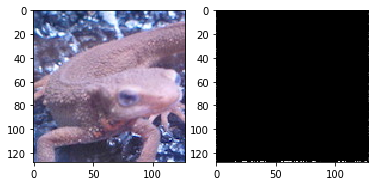

In [8]:
#43 ?????????????????????????????????????
def canny_edge4(edge, ht=50, lt=20):
    out = edge.copy()
    
    h, w = edge.shape
    for i in range(1, h-1):
        for j in range(1, w-1):
            if edge[i, j] >= ht:
                out[i, j] = 255
            elif edge[i, j] <= lt:
                out[i, j] = 0
            else:
                if np.max(edge[i-1:i+2, j-1:j+2]) >= ht:
                    out[i, j] = 255
                else:
                    out[i, j] = 0
    out = out.astype(np.uint8)

    return out


img = cv2.imread('imori.jpg')
img = img[..., ::-1]

edge, angle = canny_edge12(img)
nms = canny_edge3(edge, angle)
out = canny_edge4(nms)

plt.subplot(1, 2, 1)
plt.imshow(img, cmap='gray')
plt.subplot(1, 2, 2)
plt.imshow(out, cmap='gray')
plt.show()

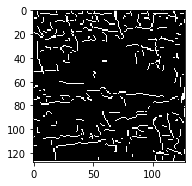

In [18]:
def Canny(img):

	# Gray scale
	def BGR2GRAY(img):
		b = img[:, :, 0].copy()
		g = img[:, :, 1].copy()
		r = img[:, :, 2].copy()

		# Gray scale
		out = 0.2126 * r + 0.7152 * g + 0.0722 * b
		out = out.astype(np.uint8)

		return out


	# Gaussian filter for grayscale
	def gaussian_filter(img, K_size=3, sigma=1.3):

		if len(img.shape) == 3:
			H, W, C = img.shape
			gray = False
		else:
			img = np.expand_dims(img, axis=-1)
			H, W, C = img.shape
			gray = True

		## Zero padding
		pad = K_size // 2
		out = np.zeros([H + pad * 2, W + pad * 2, C], dtype=np.float)
		out[pad : pad + H, pad : pad + W] = img.copy().astype(np.float)

		## prepare Kernel
		K = np.zeros((K_size, K_size), dtype=np.float)
		for x in range(-pad, -pad + K_size):
			for y in range(-pad, -pad + K_size):
				K[y + pad, x + pad] = np.exp( - (x ** 2 + y ** 2) / (2 * sigma * sigma))
		#K /= (sigma * np.sqrt(2 * np.pi))
		K /= (2 * np.pi * sigma * sigma)
		K /= K.sum()

		tmp = out.copy()

		# filtering
		for y in range(H):
			for x in range(W):
				for c in range(C):
					out[pad + y, pad + x, c] = np.sum(K * tmp[y : y + K_size, x : x + K_size, c])

		out = np.clip(out, 0, 255)
		out = out[pad : pad + H, pad : pad + W]
		out = out.astype(np.uint8)

		if gray:
			out = out[..., 0]

		return out


	# sobel filter
	def sobel_filter(img, K_size=3):
		if len(img.shape) == 3:
			H, W, C = img.shape
		else:
			H, W = img.shape

		# Zero padding
		pad = K_size // 2
		out = np.zeros((H + pad * 2, W + pad * 2), dtype=np.float)
		out[pad : pad + H, pad : pad + W] = img.copy().astype(np.float)
		tmp = out.copy()

		out_v = out.copy()
		out_h = out.copy()

		## Sobel vertical
		Kv = [[1., 2., 1.],[0., 0., 0.], [-1., -2., -1.]]
		## Sobel horizontal
		Kh = [[1., 0., -1.],[2., 0., -2.],[1., 0., -1.]]

		# filtering
		for y in range(H):
			for x in range(W):
				out_v[pad + y, pad + x] = np.sum(Kv * (tmp[y : y + K_size, x : x + K_size]))
				out_h[pad + y, pad + x] = np.sum(Kh * (tmp[y : y + K_size, x : x + K_size]))

		out_v = np.clip(out_v, 0, 255)
		out_h = np.clip(out_h, 0, 255)

		out_v = out_v[pad : pad + H, pad : pad + W]
		out_v = out_v.astype(np.uint8)
		out_h = out_h[pad : pad + H, pad : pad + W]
		out_h = out_h.astype(np.uint8)

		return out_v, out_h


	def get_edge_angle(fx, fy):
		# get edge strength
		edge = np.sqrt(np.power(fx.astype(np.float32), 2) + np.power(fy.astype(np.float32), 2))
		edge = np.clip(edge, 0, 255)

		fx = np.maximum(fx, 1e-10)
		#fx[np.abs(fx) <= 1e-5] = 1e-5

		# get edge angle
		angle = np.arctan(fy / fx)

		return edge, angle


	def angle_quantization(angle):
		angle = angle / np.pi * 180
		angle[angle < -22.5] = 180 + angle[angle < -22.5]
		_angle = np.zeros_like(angle, dtype=np.uint8)
		_angle[np.where(angle <= 22.5)] = 0
		_angle[np.where((angle > 22.5) & (angle <= 67.5))] = 45
		_angle[np.where((angle > 67.5) & (angle <= 112.5))] = 90
		_angle[np.where((angle > 112.5) & (angle <= 157.5))] = 135

		return _angle


	def non_maximum_suppression(angle, edge):
		H, W = angle.shape
		_edge = edge.copy()
		
		for y in range(H):
			for x in range(W):
					if angle[y, x] == 0:
							dx1, dy1, dx2, dy2 = -1, 0, 1, 0
					elif angle[y, x] == 45:
							dx1, dy1, dx2, dy2 = -1, 1, 1, -1
					elif angle[y, x] == 90:
							dx1, dy1, dx2, dy2 = 0, -1, 0, 1
					elif angle[y, x] == 135:
							dx1, dy1, dx2, dy2 = -1, -1, 1, 1
					if x == 0:
							dx1 = max(dx1, 0)
							dx2 = max(dx2, 0)
					if x == W-1:
							dx1 = min(dx1, 0)
							dx2 = min(dx2, 0)
					if y == 0:
							dy1 = max(dy1, 0)
							dy2 = max(dy2, 0)
					if y == H-1:
							dy1 = min(dy1, 0)
							dy2 = min(dy2, 0)
					if max(max(edge[y, x], edge[y + dy1, x + dx1]), edge[y + dy2, x + dx2]) != edge[y, x]:
							_edge[y, x] = 0

		return _edge

	def hysterisis(edge, HT=100, LT=30):
		H, W = edge.shape

		# Histeresis threshold
		edge[edge >= HT] = 255
		edge[edge <= LT] = 0

		_edge = np.zeros((H + 2, W + 2), dtype=np.float32)
		_edge[1 : H + 1, 1 : W + 1] = edge

		## 8 - Nearest neighbor
		nn = np.array(((1., 1., 1.), (1., 0., 1.), (1., 1., 1.)), dtype=np.float32)

		for y in range(1, H+2):
				for x in range(1, W+2):
						if _edge[y, x] < LT or _edge[y, x] > HT:
								continue
						if np.max(_edge[y-1:y+2, x-1:x+2] * nn) >= HT:
								_edge[y, x] = 255
						else:
								_edge[y, x] = 0

		edge = _edge[1:H+1, 1:W+1]
								
		return edge

	# grayscale
	gray = BGR2GRAY(img)

	# gaussian filtering
	gaussian = gaussian_filter(gray, K_size=5, sigma=1.4)

	# sobel filtering
	fy, fx = sobel_filter(gaussian, K_size=3)

	# get edge strength, angle
	edge, angle = get_edge_angle(fx, fy)

	# angle quantization
	angle = angle_quantization(angle)

	# non maximum suppression
	edge = non_maximum_suppression(angle, edge)

	# hysterisis threshold
	out = hysterisis(edge, 50, 20)

	return out


# Read image
img = cv2.imread("imori.jpg").astype(np.float32)

# Canny
edge = Canny(img)

out = edge.astype(np.uint8)


plt.subplot(1, 2, 1)
plt.imshow(out, cmap='gray')
plt.show()

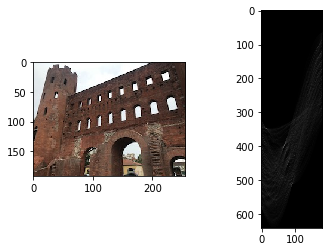

In [10]:
#44
def hough1(img):
    h, w = img.shape
    rmax = np.ceil(np.sqrt(np.power(h, 2) + np.power(w, 2))).astype(np.int)
    voting = np.zeros((rmax*2, 180), dtype=np.int)
    
    idx = np.where(img == 255)
    for y, x in zip(idx[0], idx[1]):
        for theta in range(180):
            t = np.pi / 180 * theta
            rho = int(x * np.cos(t) + y * np.sin(t))
            voting[rho+rmax, theta] += 1
    
    voting = voting.astype(np.uint8)
    return voting

img = cv2.imread('thorino.jpg')
img = img[..., ::-1]

edge = Canny(img)
out = hough1(edge)

plt.subplot(1, 2, 1)
plt.imshow(img)
plt.subplot(1, 2, 2)
plt.imshow(out, cmap='gray')
plt.show()

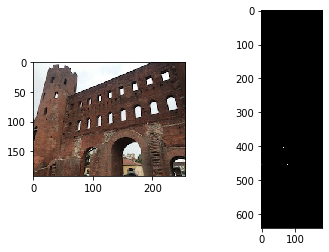

In [11]:
#45
def hough2(img):
    out = np.zeros_like(img)
    h, w = img.shape
    for y in range(1, h-1):
        for x in range(1, w-1):
            if np.max(img[y-1:y+2, x-1:x+2]) == img[y, x]:
                out[y, x] = img[y, x]
                
    idx_x = np.argsort(out.ravel())[::-1][:20]
    idx_y = idx_x.copy()
    x = idx_x % 180
    y = idx_y // 180
    out = np.zeros_like(out, dtype=np.int)
    out[y, x] = 255
    return out


img = cv2.imread('thorino.jpg')
img = img[..., ::-1]

edge = Canny(img)
out1 = hough1(edge)
out2 = hough2(out1)

plt.subplot(1, 2, 1)
plt.imshow(img)
plt.subplot(1, 2, 2)
plt.imshow(out2, cmap='gray')
plt.show()

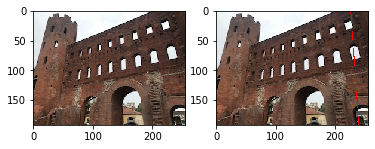

In [12]:
#46 ???????????????????????
def hough2(img):
    h, w = img.shape
    for y in range(h):
        for x in range(180):
            x1 = max(x-1, 0)
            x2 = min(x+2, 180)
            y1 = max(y-1, 0)
            y2 = min(y+2, h-1)
            if np.max(img[y1:y2, x1:x2]) == img[y, x] and img[y, x] != 0:
                pass
            else:
                img[y, x] = 0
    
    return img


def hough3(hough, img):
    h, w, _ = img.shape
    rmax, _ = hough.shape
    out = img.copy()
    
    idx_x = np.argsort(out.ravel())[::-1][:20]
    idx_y = idx_x.copy()
    thetas = idx_x % 180
    rhos = idx_y // 180 - rmax / 2
    
    for theta, rho in zip(thetas, rhos):
        t = np.pi / 180. * theta
        for x in range(w):
            if np.sin(t) != 0:
                y = int((-np.cos(t) / np.sin(t)) * x + rho / np.sin(t))
                if y < 0 or h <= y:
                    continue
                out[y, x] = [255, 0, 0]
        for y in range(h):
            if np.cos(t) != 0:
                x = int((-np.sin(t) / np.cos(t)) * y + rho / np.cos(t))
                if x < 0 or w <= x:
                    continue
                out[y, x] = [255, 0, 0]
    
    out = out.astype(np.uint8)
    return out
                
    
img = cv2.imread('thorino.jpg')
img = img[..., ::-1]

edge = Canny(img)
out1 = hough1(edge)
out2 = hough2(out1)
out3 = hough3(out2, img)

plt.subplot(1, 2, 1)
plt.imshow(img)
plt.subplot(1, 2, 2)
plt.imshow(out3)
plt.show()

In [13]:
def otsu_binarization(img):
    img = rgb2gray(img)
    out = img.copy()
    max_sigma = 0
    max_t = 0
    H, W = img.shape
    for _t in range(1, 256):
        v0 = out[np.where(out < _t)]
        m0 = np.mean(v0) if len(v0) > 0 else 0.
        w0 = len(v0) / (H * W)
        v1 = out[np.where(out >= _t)]
        m1 = np.mean(v1) if len(v1) > 0 else 0.
        w1 = len(v1) / (H * W)
        sigma = w0 * w1 * ((m0 - m1) ** 2)
        if sigma > max_sigma:
            max_sigma = sigma
            max_t = _t

    print("threshold >>", max_t)
    th = max_t
    out[out < th] = 0
    out[out >= th] = 255

    return out

threshold >> 127


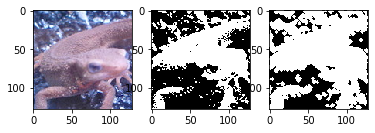

In [14]:
#47
def dilate(img):
    out = img.copy()
    k = np.array(((0,1,0), (1,0,1), (0,1,0)), dtype=np.int)
    
    h, w = img.shape
    for i in range(1, h-1):
        for j in range(1, w-1):
            if img[i, j] == 0 and np.sum(img[i-1:i+2, j-1:j+2] * k) >= 255:
                out[i, j] = 255
                
    return out


img = cv2.imread('imori.jpg')
img = img[..., ::-1]

bi = otsu_binarization(img)
out = dilate(bi)
out = dilate(out)

plt.subplot(1, 3, 1)
plt.imshow(img)
plt.subplot(1, 3, 2)
plt.imshow(bi, cmap='gray')
plt.subplot(1, 3, 3)
plt.imshow(out, cmap='gray')
plt.show()

threshold >> 127


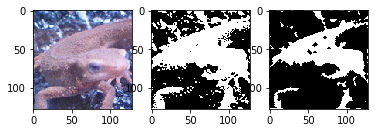

In [15]:
#48
def erosion(img):
    out = img.copy()
    k = np.array(((0,1,0), (1,0,1), (0,1,0)), dtype=np.int)
    
    h, w = img.shape
    for i in range(1, h-1):
        for j in range(1, w-1):
            if img[i, j] == 255 and np.sum(img[i-1:i+2, j-1:j+2] * k) < 255*4:
                out[i, j] = 0
                
    return out


img = cv2.imread('imori.jpg')
img = img[..., ::-1]

bi = otsu_binarization(img)
out = erosion(bi)
out = erosion(out)

plt.subplot(1, 3, 1)
plt.imshow(img)
plt.subplot(1, 3, 2)
plt.imshow(bi, cmap='gray')
plt.subplot(1, 3, 3)
plt.imshow(out, cmap='gray')
plt.show()

threshold >> 127


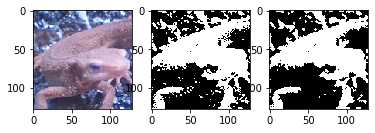

In [16]:
#49
def opening(img, n=1):
    e = erosion(img)
    d = dilate(e)
    return d


img = cv2.imread('imori.jpg')
img = img[..., ::-1]

bi = otsu_binarization(img)
out = opening(bi)

plt.subplot(1, 3, 1)
plt.imshow(img)
plt.subplot(1, 3, 2)
plt.imshow(bi, cmap='gray')
plt.subplot(1, 3, 3)
plt.imshow(out, cmap='gray')
plt.show()

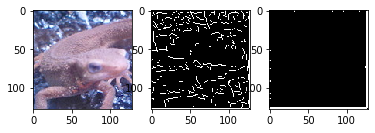

In [20]:
#50
def closing(img, n=1):
    d = dilate(img)
    if n > 1:
        for i in range(n-1):
            d = dilate(d)
    e = erosion(d)
    if n > 1:
        for i in range(n-1):
            e = erosion(e)
    return e


img = cv2.imread('imori.jpg')
img = img[..., ::-1]

canny = Canny(img)
out = opening(canny)

plt.subplot(1, 3, 1)
plt.imshow(img)
plt.subplot(1, 3, 2)
plt.imshow(bi, cmap='gray')
plt.subplot(1, 3, 3)
plt.imshow(out, cmap='gray')
plt.show()